In [1]:
from __future__ import division, print_function, unicode_literals

In [2]:
MPI_Parallelization=['Active','InActive'][1]
Save_Results=['Active','InActive'][0]

## Inputs

In [3]:

Ng=128; # number of grid points in the DNS setup
Np=16; # number of processor used to run DNS (number of output files in each realization)
"""
the DNS data generated by a pecnil decomposition. For instance for Ng=16, we would have nx=4,ny=4,nz=1. 
Aslo, in this 2d decomposition, we have (rank0,rank3,rank12,rank15)=(top left, top right, bottom left, bottom right)
"""
DNSdata_time_Step=[5550, 5700, 5850, 15450][2]

Case_ID={'Re':90,'Fr':'\infty','TStep':75,'TStep_B':5025,'TStep_E':15000}
Version='01'
read_in_folder='data_DNS_Npr_16/New folder' # folder that we read in the data from
file_names_leading='Phy_Vel_VelG.'

## Import Libraries

In [4]:
# Import the required modules
import numpy as np
import matplotlib.pyplot as plt
# This makes the plots appear inside the notebook
#%matplotlib inline
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import os
import sys 
from scipy.linalg import expm, sinm, cosm
#import odespy, numpy
import time
import pickle
import argparse
import pandas as pd
from decimal import Decimal
# Read HDF5
import h5py
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
from IPython.display import HTML
if MPI_Parallelization=='InActive':
     Case_Ids=np.arange(0)
    
else:
    from mpi4py import MPI
    comm = MPI.COMM_WORLD
    Case_Ids=np.arange(comm.size)

In [5]:
#from matplotlib.pyplot import *

# Changing font to stix; setting specialized math font properties as directly as possible
#from matplotlib import rc
#rc('text', usetex=True)
plt.rcParams['mathtext.fontset'] = 'custom'
#rcParams['mathtext.it'] = 'STIXGeneral:italic'
plt.rcParams['mathtext.bf'] = 'STIXGeneral:bold'

plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

## Reading/Saving Directory

In [6]:
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

# N_BVF_str=format_e(Decimal(str(N_BVF))).replace(".", "p")
# tstep_str=format_e(Decimal(str(tstep))).replace(".", "p")

In [7]:
PROJECT_ROOT_DIR = "."
PROJECT_Read_DIR=read_in_folder
PROJECT_SAVE_DIR = "PPResults_Turbulence_"+Version
#makes the directory if it doesn't exist.

if MPI_Parallelization=='InActive':
    if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
        print('Saving directory didn\'t exist, creating now.')
        os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
    else:
        print('Saving directory exists.') 

else:
    if comm.rank == 0:
        if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
            print('Saving directory didn\'t exist, creating now.')
            os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
        else:
            print('Saving directory exists.') 
        
        
        
#a simple defined helper function.
def savepdf(fig,name):
    fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+name+'.pdf',transparent=True) 
def savepng(fig,name):
    fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+name+'.png')    
def save_obj(obj, obj_name):
    with open(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+ obj_name+ '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(obj_name):
    with open(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+ obj_name+'.pkl', 'rb') as f:
        return pickle.load(f)    

Saving directory exists.


## Read in data

In [8]:


U_Phy=np.zeros((Ng,Ng,Ng))+np.inf
V_Phy=np.zeros_like(U_Phy)+np.inf
W_Phy=np.zeros_like(U_Phy)+np.inf


row_coordinate=np.zeros_like(U_Phy).astype(int) # row direction
col_coordinate=np.zeros_like(U_Phy).astype(int) # column direction
dep_coordinate=np.zeros_like(U_Phy).astype(int) # depth direction


file_TimeStep=('%06.0f' % Decimal(DNSdata_time_Step))

for b in range(0,Np): # (0,16)
    file_Rank=('%06.0f' % Decimal(b))
    filename=(file_names_leading+file_TimeStep+'.h5.'+file_Rank)
    
    
    print(filename)
    f = h5py.File(PROJECT_Read_DIR+'/'+filename, 'r')
    
    
    i_cell_ID= f['i_cell_ID'] # varies in depth
    j_cell_ID= f['j_cell_ID'] # varies horizontally (from left to right)
    k_cell_ID= f['k_cell_ID'] # varies vertically (from top to bottom)
    
    i_cell_ID_max=np.amax(i_cell_ID )
    i_cell_ID_min=np.amin(i_cell_ID )
    j_cell_ID_max=np.amax(j_cell_ID )
    j_cell_ID_min=np.amin(j_cell_ID )
    k_cell_ID_max=np.amax(k_cell_ID )
    k_cell_ID_min=np.amin(k_cell_ID )
    
#     print("i_cell_ID_max=%d,i_cell_ID_min=%d" %(i_cell_ID_max,i_cell_ID_min))
#     print("j_cell_ID_max=%d,j_cell_ID_min=%d" %(j_cell_ID_max,j_cell_ID_min))
#     print("k_cell_ID_max=%d,k_cell_ID_min=%d" %(k_cell_ID_max,k_cell_ID_min))
    
    row_coordinate[k_cell_ID_min-1:k_cell_ID_max, j_cell_ID_min-1:j_cell_ID_max, i_cell_ID_min-1:i_cell_ID_max]=k_cell_ID
    col_coordinate[k_cell_ID_min-1:k_cell_ID_max, j_cell_ID_min-1:j_cell_ID_max, i_cell_ID_min-1:i_cell_ID_max]=j_cell_ID
    dep_coordinate[k_cell_ID_min-1:k_cell_ID_max, j_cell_ID_min-1:j_cell_ID_max, i_cell_ID_min-1:i_cell_ID_max]=i_cell_ID
    
    U_Phy[k_cell_ID_min-1:k_cell_ID_max, j_cell_ID_min-1:j_cell_ID_max, i_cell_ID_min-1:i_cell_ID_max]=f['Phy_U'][:]
    V_Phy[k_cell_ID_min-1:k_cell_ID_max, j_cell_ID_min-1:j_cell_ID_max, i_cell_ID_min-1:i_cell_ID_max]=f['Phy_V'][:]
    W_Phy[k_cell_ID_min-1:k_cell_ID_max, j_cell_ID_min-1:j_cell_ID_max, i_cell_ID_min-1:i_cell_ID_max]=f['Phy_W'][:]

    f.close()
    

Phy_Vel_VelG.005850.h5.000000
Phy_Vel_VelG.005850.h5.000001
Phy_Vel_VelG.005850.h5.000002
Phy_Vel_VelG.005850.h5.000003
Phy_Vel_VelG.005850.h5.000004
Phy_Vel_VelG.005850.h5.000005
Phy_Vel_VelG.005850.h5.000006
Phy_Vel_VelG.005850.h5.000007
Phy_Vel_VelG.005850.h5.000008
Phy_Vel_VelG.005850.h5.000009
Phy_Vel_VelG.005850.h5.000010
Phy_Vel_VelG.005850.h5.000011
Phy_Vel_VelG.005850.h5.000012
Phy_Vel_VelG.005850.h5.000013
Phy_Vel_VelG.005850.h5.000014
Phy_Vel_VelG.005850.h5.000015


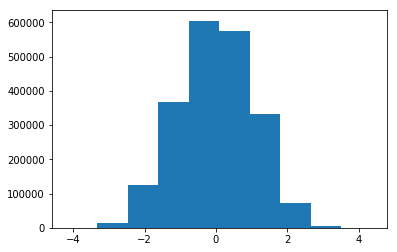

In [9]:
plt.hist(U_Phy.ravel())
pass

In [10]:
np.sort(U_Phy.ravel())

array([-4.17024124, -3.86170889, -3.85967909, ...,  4.27499586,
        4.28457324,  4.35470695])

In [11]:
np.count_nonzero(~np.isnan(U_Phy))

2097152

In [12]:
print("U_Phy.mean()=%f,V_Phy.mean()=%f,W_Phy.mean()=%f"%(U_Phy.mean(),V_Phy.mean(),W_Phy.mean()))
print("U_Phy.max()=%f,V_Phy.max()=%f,W_Phy.max()=%f"%(U_Phy.max(),V_Phy.max(),W_Phy.max()))
print("U_Phy.min()=%f,V_Phy.min()=%f,W_Phy.min()=%f"%(U_Phy.min(),V_Phy.min(),W_Phy.min()))

U_Phy.mean()=0.000000,V_Phy.mean()=-0.000000,W_Phy.mean()=0.000000
U_Phy.max()=4.354707,V_Phy.max()=4.140574,W_Phy.max()=4.719661
U_Phy.min()=-4.170241,V_Phy.min()=-4.756042,W_Phy.min()=-4.504842


In [13]:
h5py.File(PROJECT_Read_DIR+'/'+filename, 'r')['Phy_U'][:].shape

(8, 128, 128)

In [14]:
import pyUSID as usid

print('-------------------------')
usid.hdf_utils.print_tree(h5py.File(PROJECT_Read_DIR+'/'+filename, 'r'))
print('-------------------------')

-------------------------
/
├ Phy_U
├ Phy_V
├ Phy_W
├ dUdxG
├ dUdyG
├ dUdzG
├ dVdxG
├ dVdyG
├ dVdzG
├ dWdxG
├ dWdyG
├ dWdzG
├ i_cell_ID
├ j_cell_ID
├ k_cell_ID
├ trace_A
-------------------------


## Plotting to check if the cordinates are as expected

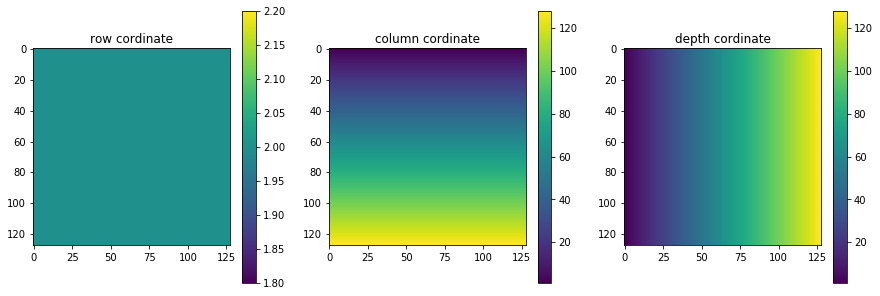

In [15]:
fig,ax=plt.subplots(nrows=1, ncols=3,figsize=(15,5))
i_d_min,i_d_max=1,2
j_d_min,j_d_max=0,128
k_d_min,k_d_max=0,128

plt.colorbar(ax[0].imshow(row_coordinate[i_d_min:i_d_max,j_d_min:j_d_max,k_d_min:k_d_max].squeeze()),ax=ax[0])
ax[0].set_title("row cordinate")
plt.colorbar(ax[1].imshow(col_coordinate[i_d_min:i_d_max,j_d_min:j_d_max,k_d_min:k_d_max].squeeze()),ax=ax[1])
ax[1].set_title("column cordinate")
plt.colorbar(ax[2].imshow(dep_coordinate[i_d_min:i_d_max,j_d_min:j_d_max,k_d_min:k_d_max].squeeze()),ax=ax[2])
ax[2].set_title("depth cordinate")
# ax[0].grid()
pass

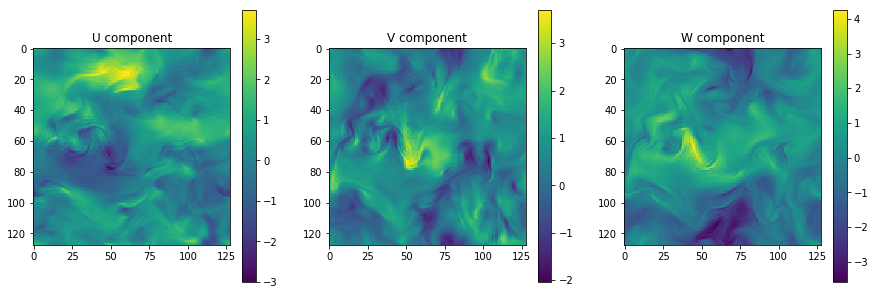

In [16]:
fig,ax=plt.subplots(nrows=1, ncols=3,figsize=(15,5))
i_d_min,i_d_max=3,4
j_d_min,j_d_max=0,128
k_d_min,k_d_max=0,128

plt.colorbar(ax[0].imshow(U_Phy[i_d_min:i_d_max,j_d_min:j_d_max,k_d_min:k_d_max].squeeze()),ax=ax[0])
ax[0].set_title("U component")
plt.colorbar(ax[1].imshow(V_Phy[i_d_min:i_d_max,j_d_min:j_d_max,k_d_min:k_d_max].squeeze()),ax=ax[1])
ax[1].set_title("V component")
plt.colorbar(ax[2].imshow(W_Phy[i_d_min:i_d_max,j_d_min:j_d_max,k_d_min:k_d_max].squeeze()),ax=ax[2])
ax[2].set_title("W component")
# ax[0].grid()
pass

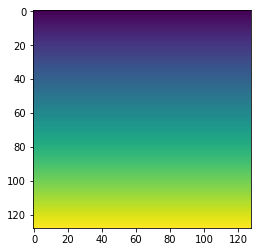

In [17]:
plt.imshow(col_coordinate[0])
pass

In [18]:
# %%capture
# steps=Ng
# sim=U_Phy
# fig = plt.figure(figsize=(6,6))
# im = plt.imshow(sim[0], vmin=-5, vmax=5)

# def updatefig(j):
#     im.set_array(sim[j])
#     return [im]

# ani = animation.FuncAnimation(fig, updatefig, frames=range(steps), 
#                               interval=1000, blit=False);

In [19]:
# %%time

# HTML(ani.to_jshtml())

In [20]:
%%capture
from mpl_toolkits.axes_grid1 import make_axes_locatable
steps=Ng
sim=U_Phy
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
# div = make_axes_locatable(ax)
# cax = div.append_axes('right', '5%', '5%')

im = plt.imshow(sim[0])
cb = fig.colorbar(im)
tx = ax.set_title('Frame 0')
def updatefig(j):
    im.set_array(sim[j])
    im.set_clim(np.min(sim), np.max(sim))
    tx.set_text('Frame {0}'.format(j))
    return [im]

ani = animation.FuncAnimation(fig, updatefig, frames=range(steps), 
                              interval=1000, blit=False);

In [21]:
%%time

HTML(ani.to_jshtml())

Wall time: 8.36 s


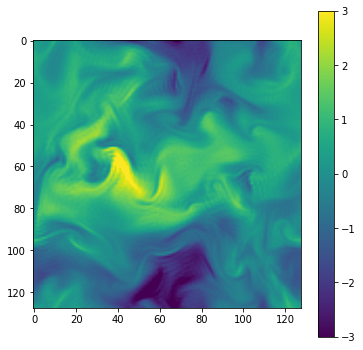

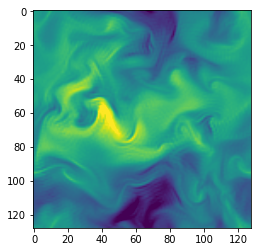

In [22]:
sim=W_Phy
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
for i in range(1,3):
    im = plt.imshow(sim[i],vmin=-3, vmax=3.,interpolation ='bilinear')
    cb = fig.colorbar(im)
    plt.show()

In [ ]:
nx=ny=nz=Ng
lx=ly=lz=2*np.pi

In [ ]:
type(lx)

In [ ]:
np.var?

In [ ]:
data=U_Phy[1]
M, N = data.shape

f, ax = plt.subplots(figsize=(4.8, 4.8))
ax.imshow(data)

print((M, N), data.dtype)

F = np.fft.fftn(data)

F_magnitude = np.abs(F)
F_magnitude = np.fft.fftshift(F_magnitude)

f, ax = plt.subplots(figsize=(4.8, 4.8))

ax.imshow(np.log(1 + F_magnitude), cmap='viridis',
          extent=(-N // 2, N // 2, -M // 2, M // 2))
ax.set_title('Spectrum magnitude');

In [ ]:
np.fft.ifftn(np.fft.fftn(U_Phy))[0,0,0],U_Phy[0,0,0]
np.allclose(U_Phy,np.fft.ifftn(np.fft.fftn(U_Phy)))
np.allclose(np.fft.fftn( U_Phy ) , np.fft.fftn( U_Phy,axes=(0,1,2) ) )

In [ ]:
eta=1.46/55.8
print("eta=",eta)
factor_I_L=[1/2,1/4][0]
cut_off_freq=(0.1)*(factor_I_L)/(eta)
cut_off_freq

In [ ]:
Box_Length=2*np.pi
Nx=Ny=Nz=Ng
lx=ly=lz=Box_Length

In [ ]:
kx=np.fft.fftfreq(Nx, d=(lx/Nx));
ky=np.fft.fftfreq(Ny, d=(ly/Ny));
kz=np.fft.rfftfreq(Nz, d=(lz/Nz)); # last dimension conjugate symmetric in numpy
kxmesh,kymesh,kzmesh=np.meshgrid(kx,ky,kz,indexing='ij');
kxmesh1,kymesh1,kzmesh1=np.meshgrid(kx,ky,kz);# the default is indexing "xy"
np.allclose(kxmesh1,kxmesh)
k_abs=np.sqrt(kxmesh*kxmesh*kzmesh)
k_abs=np.where(k_abs==0,1,k_abs)
plt.hist(k_abs.ravel())

In [ ]:
kx

In [ ]:
np.linspace(-Ng/2+1,Ng/2,Ng)

In [ ]:
np.fft.fftfreq (Ng , 1./ Ng). astype ( int )

In [ ]:
np.meshgrid?

In [ ]:
kx.shape,np.allclose(kx,ky),kz

In [ ]:
Nf = Ng//2+1
kx = ky = np.fft.fftfreq (Ng , 1./ Ng).astype( int )
Nf
kz = kx [: Nf ].copy (); 
kz [-1] *= -1
K = np.array ( np.meshgrid ( kx , ky , kz ,indexing ='ij') , dtype = int )
K2 = np.sum( K*K , 0, dtype = int )
K_abs=np.where (K2 == 0, 1, np.sqrt(K2) ) . astype ( float )
#K

K.shape,K_abs.shape,np.min(K)

In [ ]:
dealias = np.array ( ( abs (K_abs) < cut_off_freq ) , dtype = bool )
####np.array (( abs (K[0]) < kmax_dealias ) *( abs (K[1]) < kmax_dealias )* ( abs (K[2]) < kmax_dealias ) , dtype = bool )
dealias# dealias*UF

In [ ]:
plt.hist(K_abs.ravel())

In [ ]:
x=np.arange(16).reshape(4,2,2)
x*10*np.ones((2,2))